# LLM - Bielik - Fine tuning - part I

## Introduction

The rise of the Large Language Models are definetely a game changer in approach to AI on various markets and branches - we can observe increased popularity of LLMs in academia, business and agriculture. Working with LLMs became a must-do task for all R&D or business departments in order to acknowledge and adapt upcoming possibilities, to stay competetive and gain business advantage. There are many players who invested bilions of USD to build their own Large Language Model and took a part in recent markets challenges by introducing their own solution trained on a different data set or to serve a different task (specialized for example in generation of poems or making a summary). At the beginning, as usual when it comes to innovation at that scale, we are thinking of endless possibilities, what kind of new opportunities we reach without putting much focus on other important factors like costs, maintanence, security, stability. Currently, we have multiple models which are production ready - many work has been done at those fields also making those LLMs more reliable and secured. One of the outcomes from this LLM race is that people noticed that it is good idea to look at smaller models, more specialized in one or two tasks, not the general ones. This specialization also is related to language supported. LLMs are broadly trained on english language data, due to the fact that more than half of websites content is written in English. Many models, paid and open source ones, have different level of quality when it comes when using them with local language. Quite often it occurs that offered quality is not enough to prove the business value for specific use case. This pushed some parties to create smaller models or suggested the finetuning with data in local language. 

## Goal
The goal of this notebook is to finetune a Polish language based LLM called Bielik, developed by SpeakLeash organization (<model page>) with the legal documents. Data is specifically chosen for this task - legal documents or, law as a general concept, are strictly connected to the particular langauge. Primary concept of legal documents is to be in line with local (polish in this case) regulations. One of the approaches is to translate documents to english and then used by the LLM. However, legal documents such as purchase agreements or any other agreements are designed by lawyers who understand the legal language nuances. They need to construct documents that are reliable, understandable by many and embedded in Polish law regulations. This requires from LLM to be more specific on many levels - starting from using prevalent data in one language and finetuning it to be able to work with more detailed task. 

## Table of contents

This notebook covers multiple steps:
1. Loading and splitting data into chunks
2. Generating new data (question and answers) for the future finetuning
3. Evaluating generated data
4. Selecting the data based on metrics 
5. Preparing the output for FT


## Loading and working with data

Data source: https://isap.sejm.gov.pl/isap.nsf/download.xsp/WDU20140000827/U/D20140827Lj.pdf 

In [1]:
import datetime
import pandas as pd
import numpy as np
from dotenv import load_dotenv, find_dotenv
import pymupdf
import uuid
from tqdm.notebook import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from src.external_requests.openai_req import OpenAIReq
from src.external_requests.prompting import PromptBuilder
from src.evaluation.distance_based import DistanceEvaluator
from src.evaluation.reporting import Reporting
import tiktoken

In [2]:
_ = load_dotenv(find_dotenv())

For this use case I am using commonly used splitter - RecursiveCharacterTextSplitter from langchain and pymudf library for parsing the PDF. Document is well formatted and doesn't contain more complex structures like graphs or tables. 

In [3]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=120)

In [4]:
path = 'data/ustawa_nr_1.pdf' # local file system
all_data = pymupdf.open(path)

In [5]:
all_chunks = []
for document in all_data:
    text_page = document.get_textpage().extractText()
    chunks_per_page = splitter.split_text(text_page)
    all_chunks.append(chunks_per_page)
        
len(all_chunks)

44

In [6]:
def get_number_of_tokens(text:str) -> str:
    encoding = tiktoken.get_encoding("cl100k_base")
    n_tokens = len(encoding.encode(text))
    return n_tokens

### Generating new data (questions) with a support of GPT 3.5

For this task the GPT 3.5 was chosen. GPT has proven itself as a great tool for text generation in many languages and also for assessing own work (this part will be covered later in the article). What is more, it has proven also it's abilities to generate structurised content. In the below code snippet there is one important remark. As presented, there are two similar variables - max_tokens and model_max_tokens. ChatGPT model support tokens limitation during an api call. However, this limitation ca be tricky as it should be considered rather as a cost guard than concise content guard. Setting model's max tokens to low number results in sentence truncation and losing information. That is the reason the second variable was introduced - max_tokens. Max_tokens variable is passed to the prompt for the model as a part of an instruction to model to instruct the model to generate succinct yet comprehensive answer within the given token limit. 

In [11]:
all_data = []
max_tokens = 500
model_max_tokens = int(max_tokens + (max_tokens*0.20))
for i, page in tqdm(enumerate(all_chunks)):
    page_id = str(uuid.uuid4())
    for chunk in enumerate(page):
        nth_chunk, text_chunk = chunk
        generated_questions = OpenAIReq().call_api(prompt=PromptBuilder.generate_questions(n_questions=4, text=chunk, tokens=max_tokens),
                                                   temperature=0.1,max_tokens=model_max_tokens)
        data = {'chunk_id': f'{page_id}_{nth_chunk}', 
                'text_chunk': text_chunk,
                'page_id': page_id,
                'generated_questions': generated_questions}
        all_data.append(data)

0it [00:00, ?it/s]

In [12]:
df = pd.DataFrame.from_dict(data=all_data)

,chunk_id,text_chunk,page_id,generated_questions
0,99e84c9e-b818-4381-8343-f294ea12ec8b_0,DYREKTYWY\nDYREKTYWA PARLAMENTU EUROPEJSKIEGO ...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie konkretne zmiany wprowadza dyrektywa P...
1,99e84c9e-b818-4381-8343-f294ea12ec8b_1,uwzględniając Traktat o funkcjonowaniu Unii Eu...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie konkretnie artykuły Traktatu o funkcjo...
2,99e84c9e-b818-4381-8343-f294ea12ec8b_2,(1)\nW komunikacie z 11 grudnia 2019 r. zatytu...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie konkretnie zmiany przewiduje Komisja E...
3,99e84c9e-b818-4381-8343-f294ea12ec8b_3,podarczego Unii. Jej celem jest przekształceni...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie są główne cele Zielonego Ładu Unii Eur...
4,99e84c9e-b818-4381-8343-f294ea12ec8b_4,tywnymi skutkami związanymi ze środowiskiem. C...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie są główne cele Zielonego Ładu w kontek...
...,...,...,...,...
844,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_5,ważonego rozwoju publikowanych przez jednostki...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne założenia dotyczące publikac...
845,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_6,i sporządza sprawozdanie na ten temat. W przeg...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne kryteria oceny krajowych sys...
846,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_7,tacji zrównoważonego rozwoju i odpowiedniej ja...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne cele zrównoważonego rozwoju ...
847,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_8,wraz z wnioskami ustawodawczymi.\nArtykuł 7\nW...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne założenia i cele zawarte w d...


Let's do some data cleaning and validating. We need a helper method to do required data preparation with validation on null values:

In [9]:
def process_df_with_questions(data: pd.DataFrame) -> pd.DataFrame:
    data['questions_splitted'] = data['generated_questions'].str.split('\n')
    data = data.explode('questions_splitted')
    data = data[~data['questions_splitted'].isna()]
    data['questions_splitted']  = data['questions_splitted'].replace(r'^\s*$', np.nan, regex=True)
    return data

df = process_df_with_questions(data=df)

In [10]:
df = df[~df['questions_splitted'].isna()]
df['questions_splitted'].isna().sum()

0

### Fetching answers for generated questions based on the text chunk
Next step is also focused on generation, but in this case we are focusing on answers to the previously generated questions. As in previous example, we also introduce a token limitation for the model, and it is passed to the prompt as part of the instruction. In this case we want to limit the answer length in order to get concise and precise answer as it is quite often expected from LLM to deliver brief answers. To support that, we set the temperature as low as possible.

In [13]:
answer_tokens = 200
df[f'answer_{answer_tokens}'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_answers_based_on_text_and_questions(text=x['text_chunk'], question= x['questions_splitted'], tokens=answer_tokens), temperature=0.0), axis=1)

To validate if GPT "listened" to our instruction with token limitation, let's count tokens and plot the histogram. As shown, the model generated answer mostly within the range of 100-300 tokens.   

In [12]:
df['n_tokens_ans_200'] = df['answer_200'].apply(lambda x: get_number_of_tokens(text=x))
pd.plotting.hist_series(df['n_tokens_ans_200'])

<Axes: >

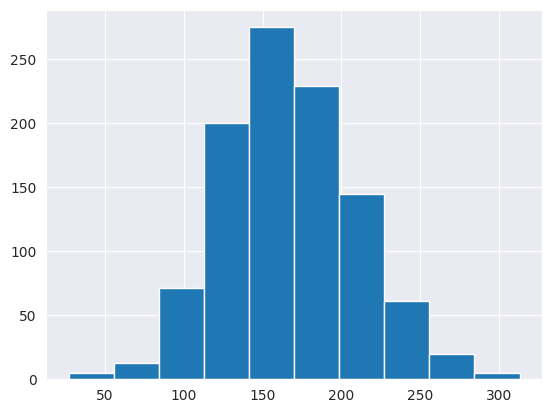

## Verifing the quality of generated answers and questions based on selected metrics
To verify the quality of our text generation in relation to text chunk there are couple metrics we can use:
- Coverage 
- Coherence (Consistency)
- Diversity (based on Word Mover Distance)
- Relevance
- Global relevance

Majority of the metrics are based on the LLM own capability to assess it's own work. This has been proven and it is often used in various evaluation frameworks like RAGAS.
Here metrics are chosen carefully based on article from Microsoft -  https://arxiv.org/abs/2401.08406

Briefly, we can describe the metrics in the way prompt instruction is constructed:
- coverage - Your task is to rate from 1 to 5 if the question can be extracted from the context.
- coherence - Your task is to rate from 1 to 5 the coherence (fluency) of the question and provide explanation.
- relevance - Your task is to rate from 1 to 5 if the provided question could be asked by a lawyer then rate 5, and rate 1 if not based on the question and context.
- global relevance - Your task is to rate from 1 to 5 if the provided question could be asked by a lawyer then rate 5, and rate 1 if not based on the question.
- diversity - not LLM based metric. To calculate this we used Word Mover Distance (WMD). 


In [21]:
df['coverage_rating'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coverage(question=x['questions_splitted'], context=x['text_chunk'])), axis=1)
pd.plotting.hist_series(df['coverage_rating'])

<Axes: >

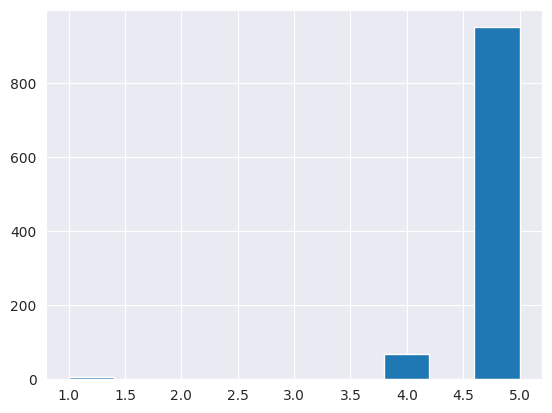

In [25]:
dist_evaluator = DistanceEvaluator()

In [26]:
df[f'wmd_question_answer_{answer_tokens}'] = df.apply(lambda x: dist_evaluator.get_diversity_by_wmd(x['questions_splitted'], x[f'answer_{answer_tokens}']), axis=1)

<Axes: >

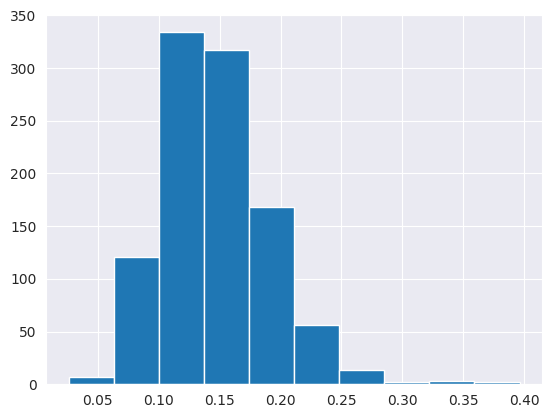

In [15]:
pd.plotting.hist_series(df['wmd_question_answer_200'])

In [28]:
df['wmd_chunk_question'] = df.apply(lambda x: dist_evaluator.get_diversity_by_wmd(x['text_chunk'], x['questions_splitted']), axis=1)

<Axes: >

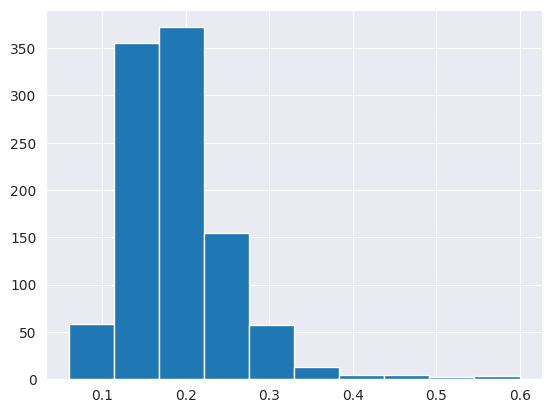

In [16]:
pd.plotting.hist_series(df['wmd_chunk_question'])

In [31]:
df['coherence'] = df['questions_splitted'].apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coherence(x)))

In [32]:
df['coherence_pl'] = df['questions_splitted'].apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coherence_pl(x)))

In [34]:
df[['coherence_rate', 'coherence_expl']] = df.coherence.str.split(',', n=1,  expand=True)
df[['coherence_rate_pl', 'coherence_expl_pl']] = df.coherence_pl.str.split('|', n=1,  expand=True)


In [35]:
df['coherence_rate'] = df.coherence_rate_pl.str.replace('(', '')
df['coherence_expl'] = df.coherence_expl_pl.str.replace(')', '')
df['coherence_expl'] = df.coherence_expl_pl.str.replace('"', '')

In [38]:
df['relevance'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_relevance(question=x['questions_splitted'], context=x['text_chunk'])),axis=1)

In [39]:
df['global_relevance'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_global_relevance(question=x['questions_splitted'])),axis=1)

## Evaluation

In [17]:
reporting = Reporting(data=df)
sim_matrix = reporting.create_similarity_matrix_for_wmd(on_column='questions_splitted')

1024it [14:30,  1.18it/s]


In [18]:
sim_matrix.shape

(1024, 1024)

#### Relevance anf global relevance

In [21]:
df['relevance'].value_counts(normalize=True)

relevance
5    0.992188
4    0.003906
1    0.002930
3    0.000977
Name: proportion, dtype: float64

<Axes: >

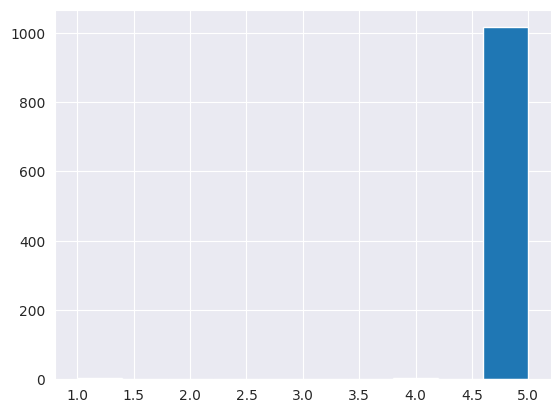

In [22]:
pd.plotting.hist_series(df['relevance'])

In [23]:
df['global_relevance'].value_counts(normalize=True)

global_relevance
5    0.993164
1    0.003906
4    0.000977
3    0.000977
2    0.000977
Name: proportion, dtype: float64

<Axes: >

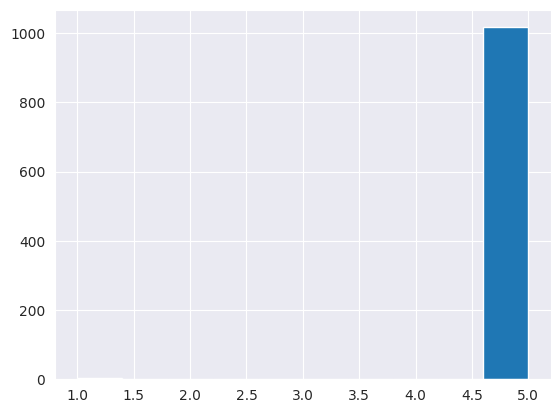

In [24]:
pd.plotting.hist_series(df['global_relevance'])

#### Coverage summary

In [43]:
df['coverage_rating'].value_counts(normalize=True)

coverage_rating
5    0.927734
4    0.065430
1    0.006836
Name: proportion, dtype: float64

<Axes: >

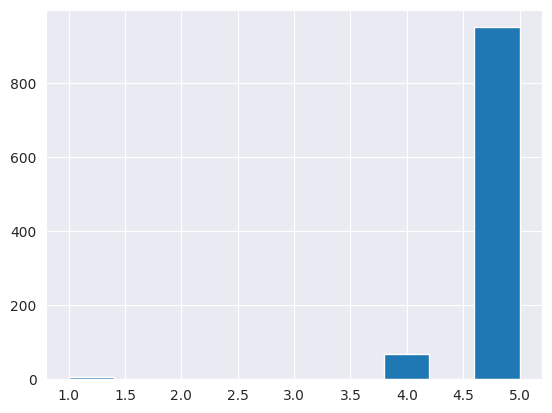

In [26]:
pd.plotting.hist_series(df['coverage_rating'])

#### Word mover distance

<Axes: >

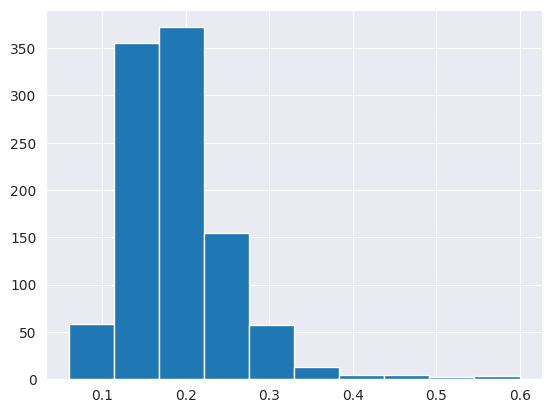

In [27]:
# WMD question <-> chunk
pd.plotting.hist_series(df['wmd_chunk_question'])

In [28]:
mean_wmd_qch = df['wmd_chunk_question'].mean()
std_wmd_qch = df['wmd_chunk_question'].std()
print(f'Mean for question to chunk for WMD is {mean_wmd_qch} with std as {std_wmd_qch}')

Mean for question to chunk for WMD is 0.18992659685328583 with std as 0.06288713143204415


<Axes: >

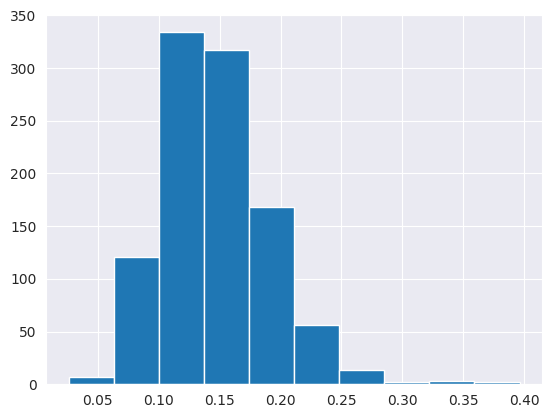

In [33]:
# WMD question <-> answer
pd.plotting.hist_series(df['wmd_question_answer_200'])

In [34]:
mean_wmd_qa = df['wmd_question_answer_200'].mean()
std_wmd_qa = df['wmd_question_answer_200'].std()
print(f'Mean for question to answer for WMD is {mean_wmd_qa} with std as {std_wmd_qa}')

Mean for question to answer for WMD is 0.1465598756315475 with std as 0.043860925168477095


In [35]:
# WMD question <-> question
std, mean = reporting.get_summary_for_wmd(sim_matrix)
print(f'Mean for question to question for WMD is {mean} with std as {std}')

Mean for question to question for WMD is 0.2319945366162956 with std as 0.058350289261069374


#### Coherence rate

In [21]:
df['coherence_rate_pl'].value_counts(normalize=True)

coherence_rate_pl
4    0.498047
3    0.489258
5    0.007812
2    0.004883
Name: proportion, dtype: float64

<Axes: >

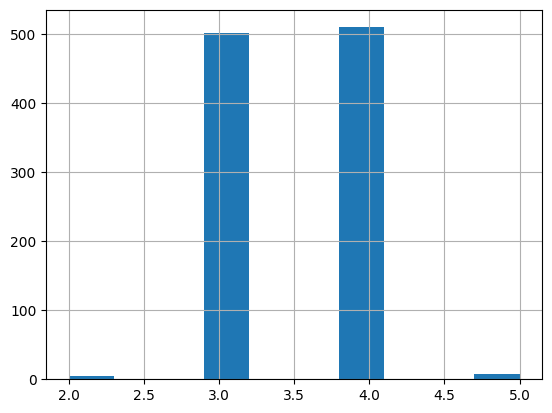

In [22]:
pd.plotting.hist_series(df['coherence_rate_pl'])

In [24]:
df['coherence_rate'] = pd.to_numeric(df.coherence_rate, errors='coerce').fillna(0) # there are some single rows with wrong values (not parsed correctly), removing them as they do not provide mush difference in the final results.
df['coherence_rate'].value_counts(normalize=True)

coherence_rate
3.0    0.454102
4.0    0.404297
2.0    0.130859
0.0    0.010742
Name: proportion, dtype: float64

<Axes: >

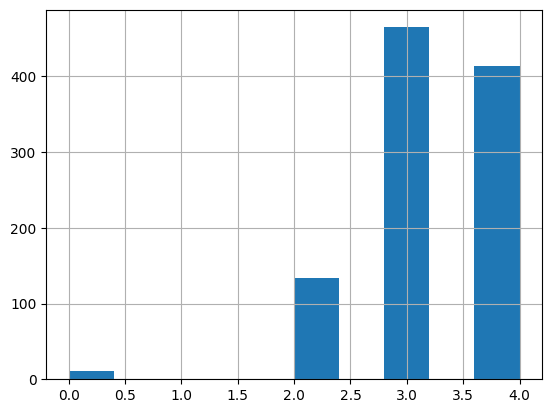

In [25]:
pd.plotting.hist_series(df['coherence_rate'])

### Evaluation Summary
From the results we can conclude that GPT prepared for us quite good dataset - majority of values are high (low in terms of similarity). The only outlier in those results is the coherence score which can be taken for further investigation and analysis. Both polish and english version are not generating the best scores - they are placed somewhere in the upper middle (3 and 4 rating).

Overall, the results have proven that generated question with support of GPT model are good enough to use them as the input instructions for the model. Now, question value pairs will be transformed into the proper structure to be later on used for fine tuning.   

## Data preparation for FT

In [21]:
qa_df_200 = df[['questions_splitted', 'answer_200']]
qa_df_200 = qa_df_200.rename(columns={'questions_splitted': 'question', 'answer_200': 'answer'})
now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
with open(f'ft_output_data/data_ft_{now}.jsonl', "w") as f:
    f.write(qa_df_200.to_json(orient='records', lines=True, force_ascii=False))

## Summary
As our last piece of code is executed, we can finish first part of this article - data preparation. I hope you enjoyed it as much as! Let's move on to the second part of the finetuning polish LLM model with our generated data. 

See ya! 

## References and sources
1. https://arxiv.org/abs/2401.08406
2. https://www.statista.com/statistics/262946/most-common-languages-on-the-internet/
3. https://medium.com/@bijit211987/the-rise-of-small-language-models-efficient-customizable-cb48ddee2aad
4. https://python.langchain.com/docs/how_to/recursive_text_splitter/
5. https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html